# **CHALLENGE COMPUTER VISION**

## **I. Presentation et preliminaires**

L'objetif du challenge est d'effectuer **une tache de classification d'images** parmis **10 classes** sachant qu'on a un dataset contenant une faible proportion d'images labelisées(**100 images labelisées**) et une plus grande proportion d'images non labelisées (**61900 images non labelisées**).
Utilisé les images labelisées seules ne permettra pas d'avoir un modele performant sachant qu'il y a de gros risque d'overfitting car le dataset labelisé est tres petit.

Nous adopterons une strategie de semi-supervised learning, c'est à dire utiliser le dataset non supervisé pour accroitre les performance du modele. Comment exploiter le potentiel du dataset non supervisé? C'est là tout l'enjeu de l'apprentissage semi-supervisé.


## **II. Import necessaire**

In [1]:
from google.colab import files
files.upload() # Choisissez votre fichier kaggle.json téléchargé
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

Saving kaggle.json to kaggle.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle competitions download -c inf473v-2023-challenge-v2

100% 7.95G/7.95G [01:03<00:00, 142MB/s]
100% 7.95G/7.95G [01:03<00:00, 134MB/s]


In [3]:
!unzip inf473v-2023-challenge-v2.zip


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: compressed_dataset/unlabelled/yxHiTLJqzVVAiLX.jpg  
  inflating: compressed_dataset/unlabelled/yxIV0xqqiuOU2Y1.jpg  
  inflating: compressed_dataset/unlabelled/yxIXtKhjmPIshbp.jpg  
  inflating: compressed_dataset/unlabelled/yxJ01x8vkzPvhdf.jpg  
  inflating: compressed_dataset/unlabelled/yxJ0ZSnmcj0Q74Z.jpg  
  inflating: compressed_dataset/unlabelled/yxJIKKmYNI25zwh.jpg  
  inflating: compressed_dataset/unlabelled/yxKbTLv13AZLMk9.jpg  
  inflating: compressed_dataset/unlabelled/yxL4aGBS42Z3Wdu.jpg  
  inflating: compressed_dataset/unlabelled/yxLxKoTVWNU88JL.jpg  
  inflating: compressed_dataset/unlabelled/yxOoH1WpwhyotpP.jpg  
  inflating: compressed_dataset/unlabelled/yxPMsYHgjFlzSBA.jpg  
  inflating: compressed_dataset/unlabelled/yxPoDn6r7RtiOyN.jpg  
  inflating: compressed_dataset/unlabelled/yxQ7iLjer2KiCgB.jpg  
  inflating: compressed_dataset/unlabelled/yxQTe78tzP1MBj8.jpg  
  inflating:

In [4]:
### IMPORT DE BASE ET BOITE A OUTILS FONDAMENTALE DU DATA SCIENTIST
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


### SKLEARN FOR CROSSVALIDATION
from sklearn.model_selection import KFold


### PYTORCH
import torch
from torch import nn
from tqdm.notebook import tqdm
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder # dataset d'image labelisées
from torch.utils.data import DataLoader,Dataset,random_split
from torch.utils.data import random_split # separation des données supervisées en données d'entrainement et de test
import torch.optim as optim
from torch.optim import Adam
from torch.cuda.amp import GradScaler, autocast



### IMAGE PREPROCESSING
from PIL import Image


In [5]:
np.random.seed(42) # Initialisation de la graine aléatoire
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **III. DATASET ET EXPLANATORY DATA ANALYSIS (EDA)**

On peut maintenat creer nos jeux de données labelisée et non labelisée. Pour cela nous allons creer 2 variables train_supervised et train_unsupervised contenant respectivement les images labélisées et non labélisées.

In [6]:
from PIL import Image
from torch.utils.data import ConcatDataset
# Définir les transformations à appliquer aux images: reshape, normalise ...
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Chemins vers les dossiers contenant les images
supervised_path = '/content/compressed_dataset/train'
unsupervised_path = '/content/compressed_dataset/unlabelled'



# Transformation pour l'augmentation des données
augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.RandomRotation(degrees=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Création du dataset d'origine
train_supervised_original = ImageFolder(root=supervised_path,transform = transform)

# Création du dataset augmenté
train_supervised_augmented = ImageFolder(root=supervised_path, transform=augmentation_transforms)
# Combinaison des datasets d'origine et augmenté
train_supervised = ConcatDataset([train_supervised_original, train_supervised_augmented])



import os
import glob

class BunchOfImagesDataset(object):
    def __init__(self, folder, transforms=None):
        self.folder = folder
        self.files = glob.glob(os.path.join(folder, '*.jpg'))
        self.transforms = transforms
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        image = Image.open(file_path).convert('RGB')
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return image
    
    def __len__(self):
        return len(self.files)

train_unsupervised = BunchOfImagesDataset(unsupervised_path, transform)


# Afficher les tailles des ensembles de données
print(f"Nombre d'images supervisées : {len(train_supervised)}")
print(f"Nombre d'images non supervisées : {len(train_unsupervised)}")


Nombre d'images supervisées : 1440
Nombre d'images non supervisées : 296874


## **IV. Modele d'apprentissage semi-supervisé: FixMatch**

**FixMatch** est une méthode d'apprentissage semi-supervisé proposée par **Sohn et al. en 2020**. 

FixMatch est une approche d'apprentissage semi-supervisé de pointe qui atteint des performances élevées sur différents benchmarks.

FixMatch combine l'apprentissage supervisé et non supervisé pour entraîner un réseau de neurones profond en utilisant à la fois des données étiquetées et non étiquetées. Il utilise une approche **mix-match** qui génère **deux versions augmentées de la même image non étiquetée et calcule la prédiction moyenne de ces deux versions**. 


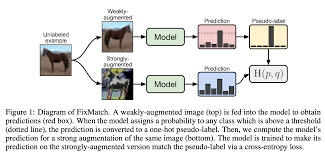





La prédiction moyenne est ensuite comparée à la prédiction des données étiquetées pour calculer la perte. Ce processus est répété pour plusieurs itérations afin d'améliorer la précision du modèle.


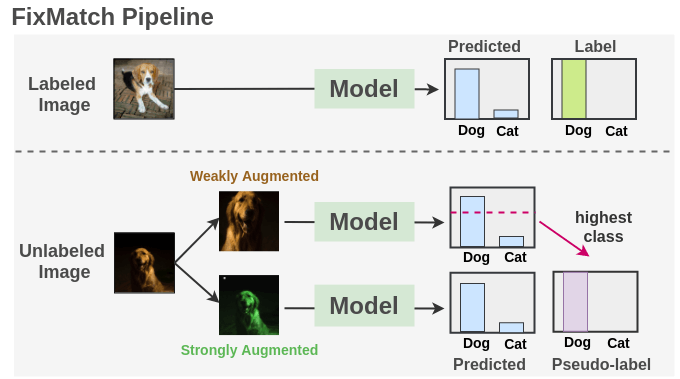

FixMatch s'est avéré très efficace dans plusieurs benchmarks de classification d'images, atteignant des performances de pointe avec beaucoup moins de données étiquetées.

[Le papier original des chercheurs de Google sur FixMatch](https://papers.nips.cc/paper/2020/file/06964dce9addb1c5cb5d6e3d9838f733-Paper.pdf)

On peut resumer le processus d'entraînement de FixMatch comme suit:

1. Les données étiquetées et non étiquetées sont préparées avec des transformations de données aléatoires.

2. Les données étiquetées sont utilisées pour entraîner le modèle de manière supervisée en utilisant une fonction de perte de classification croisée.

3. Les données non étiquetées sont utilisées pour entraîner le modèle de manière non supervisée en utilisant des pseudo-étiquettes générées par le modèle lui-même.

4. Pour générer des pseudo-étiquettes, une image faiblement augmentée est donnée en entrée au modèle pour obtenir les prédictions. Si la probabilité de la classe prédite dépasse un certain seuil, la prédiction est convertie en une pseudo-étiquette one-hot.

5. Le modèle est ensuite entraîné avec une forte augmentation de l'image non étiquetée en utilisant une fonction de perte de classification croisée avec la pseudo-étiquette correspondante.

### **Hyperparamètres du modèle**

In [19]:
learning_rate = 0.001
labeled_batch_size = 32 #16
unlabeled_batch_size = 20*32
val_batch_size = 32 #64
batch_size = 64
val_split = 0.1
num_folds = 3
threshold = 0.95
alpha = 0.75
consistency_weight = 4.0
unlabeled_weight = 0.75





# Define the CTAugment transformation
ct_augment = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Define the Cutout transformation
cutout = transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3))

# Apply the transformations to your data
strong_augment= transforms.Compose([
    ct_augment,
    cutout,
])



# Define the transformation for weak augmentation
# Random horizontal flipping with a probability of 50% for all datasets except SVHN
# Random translation by up to 12.5% vertically and horizontally
weak_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125))
])

### **Modele de base pour les donnees labelisees**. 

On definit le modele de base qui servira a entraine les donnees labelisees.

In [20]:
# TODO: Tester aussi des ViT,VGGNet, ou autre architecture de classification d image
num_classes = 48
import torchvision.models as models
#class ResNetFinetune(nn.Module):
 #   def __init__(self, num_classes, frozen=False):
   #     super().__init__()

   #     self.backbone = model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
     #   self.backbone.fc = nn.Identity()
      #  if frozen:
       #     for param in self.backbone.parameters():
               # param.requires_grad = False
        #self.classifier = nn.Linear(2048, num_classes)

    #def forward(self, x):
       # x = self.backbone(x)
        #x = self.classifier(x)
        #return x

import torch
import torch.nn as nn
import torchvision.models as models

class VGGNetFinetune(nn.Module):
    def __init__(self, num_classes, frozen=False):
        super().__init__()

        self.backbone = model = models.vgg16(pretrained=True)
        self.backbone.classifier = nn.Identity()
        
        if frozen:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        self.classifier = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.backbone.features(x)
        x = x.view(x.size(0), -1)
        x = self.backbone.classifier(x)
        x = self.classifier(x)
        return x

# TODO: Tester aussi des ViT,VGGNet, ou autre architecture de classification d image
num_classes = 48

class ResNetFinetune(nn.Module):
    def __init__(self, num_classes, frozen=False):
        super().__init__()

        self.backbone = model = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Identity()
        if frozen:
            for param in self.backbone.parameters():
                param.requires_grad = False
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

L'algorithme de Fixmatch est composé de deux étapes principales: 

* la première étape consiste à augmenter les images non labellisées par une transformation faible (cf lepapier de Google) et à les passer dans le modèle finetuné pour obtenir des prédictions faibles. 

* La deuxième étape consiste à appliquer une augmentation beaucoup plus forte (cf le papier de Google) aux mêmes images non labellisées et à les passer à nouveau dans le modèle pour obtenir des prédictions fortes. Les prédictions fortes sont utilisées pour entraîner le modèle, tandis que les prédictions faibles sont utilisées pour étendre le set d'images labellisées : ce sont des pseudo-labels.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class FixMatchv2(nn.Module):
    def __init__(self, model, consistency_weight, unlabeled_weight):
        super(FixMatchv2, self).__init__()
        self.model = model
        self.consistency_weight = consistency_weight
        self.unlabeled_weight = unlabeled_weight

    def forward(self, labeled_images, labeled_labels, unlabeled_images_weak, unlabeled_images_strong):
        # Get labeled image predictions and losses
        labeled_preds = self.model(labeled_images)
        labeled_loss = nn.CrossEntropyLoss()(labeled_preds, labeled_labels)
        
        # Generate pseudo labels for unlabeled images
        with torch.no_grad():
            unlabeled_preds_weak = self.model(unlabeled_images_weak)
            pseudo_labels = torch.argmax(unlabeled_preds_weak, dim=1)
            confidence_mask = torch.max(torch.softmax(unlabeled_preds_weak, dim=1), dim=1)[0] >= 0.95

        # Select confidently labeled unlabeled samples
        unlabeled_images_strong_go = unlabeled_images_strong
        unlabeled_images_strong = unlabeled_images_strong[confidence_mask]
        pseudo_labels = pseudo_labels[confidence_mask]

        if unlabeled_images_strong.shape[0] == 0:
            # No confident examples remaining
            unlabeled_loss = torch.tensor(0.0, device=labeled_images.device)
            consistency_loss = torch.tensor(0.0, device=labeled_images.device)
        else:
            # Get unlabeled image predictions and losses
            unlabeled_preds_strong = self.model(unlabeled_images_strong)
            unlabeled_loss = self.unlabeled_weight * nn.CrossEntropyLoss()(unlabeled_preds_strong, pseudo_labels)

            # Get consistency loss
            with torch.no_grad():
                # Resize the tensors to have the same shape
                unlabeled_preds_strong_go = self.model(unlabeled_images_strong_go)
                unlabeled_preds_weak = torch.softmax(unlabeled_preds_weak, dim=1)
                unlabeled_preds_strong = torch.softmax(unlabeled_preds_strong_go, dim=1)
            consistency_loss = self.consistency_weight * nn.MSELoss()(unlabeled_preds_weak, unlabeled_preds_strong)

        # Calculate total loss
        total_loss = labeled_loss + unlabeled_loss + consistency_loss

        return total_loss


In [22]:
# Define the training loop
def train(model, device, supervised_loader,val_loader,unsupervised_loader,optimizer, scheduler, consistency_weight, unlabeled_weight, epochs, best_acc):
    scaler = GradScaler()
    tab_acc_train = []
    tab_acc_val = []
    ema_decay = 0.99
    ema_model = ResNetFinetune(num_classes=48, frozen=True).to(device)
    ema_model.load_state_dict(model.state_dict())
    ema_model.eval()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for (labeled_images, labeled_labels), unlabeled_images_weak in tqdm(zip(supervised_loader, unsupervised_loader), desc=f"Epoch {epoch+1}: ", total=len(supervised_loader)):
            unlabeled_images_strong = strong_augment(unlabeled_images_weak)
            unlabeled_images_weak = weak_augment(unlabeled_images_weak)
            labeled_images = weak_augment(labeled_images)
            labeled_images, labeled_labels = labeled_images.to(device), labeled_labels.to(device)
            unlabeled_images_weak, unlabeled_images_strong = unlabeled_images_weak.to(device), unlabeled_images_strong.to(device)
            optimizer.zero_grad()
            total_loss = FixMatchv2(model, consistency_weight, unlabeled_weight)(labeled_images,labeled_labels, unlabeled_images_weak, unlabeled_images_strong)
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            
            scaler.update()
            train_loss += total_loss.item()

            # Calculate accuracy
            labeled_preds = model(labeled_images)
            _, predicted = labeled_preds.max(1)
            train_total += labeled_labels.size(0)
            train_correct += predicted.eq(labeled_labels).sum().item()

            # Update scheduler
            scheduler.step()
            with torch.no_grad():
                for ema_param, param in zip(ema_model.parameters(), model.parameters()):
                    ema_param.data.mul_(ema_decay).add_((1 - ema_decay) * param.data)

            """if batch_idx % 50 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * labeled_images.size(0), len(supervised_loader.dataset),
                100. * batch_idx / len(supervised_loader), total_loss.item()))"""

      # Calculate average loss and accuracy
        train_loss /= len(supervised_loader)
        train_acc = 100. * train_correct / train_total
        tab_acc_train.append(train_acc)
        print('Train Epoch: {}\tAverage Loss: {:.6f}\tAccuracy: {:.2f}%'.format(epoch, train_loss, train_acc))

      # Evaluate on validation set
        model.eval()
        ema_model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                preds = ema_model(images)
                val_loss += nn.CrossEntropyLoss()(preds, labels).item()

                # Calculate accuracy
                _, predicted = preds.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        tab_acc_val.append(val_acc)
        print('Validation Epoch: {}\tAverage Loss: {:.6f}\tAccuracy: {:.2f}%'.format(epoch, val_loss, val_acc))

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(ema_model.state_dict(), 'best_model.pth')

    return ema_model, mean(tab_acc_train),mean(tab_acc_val)

In [31]:
from numpy.core.fromnumeric import mean

consistency_weight = 0
unlabeled_weight = 1
epochs = 50

def main():
  # Create 5-fold cross-validation splits
    kfold = KFold(n_splits=2, shuffle=True, random_state=42)
    best_acc = 0.0
    acc_fold_tab = []
    unsupervised_loader = DataLoader(train_unsupervised, batch_size=128, shuffle=True, num_workers=2, drop_last=True,pin_memory=True)
    for fold, (train_indices, val_indices) in enumerate(kfold.split(train_supervised)):
      print()
      print(f"##############################   fold {fold + 1}    ########################")
      print()
      # Create data loaders
      train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
      val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
      train_loader = DataLoader(train_supervised, batch_size=16, sampler=train_sampler, num_workers=2, pin_memory=True)
      val_loader = DataLoader(train_supervised, batch_size=16, sampler=val_sampler, num_workers=2, pin_memory=True)
      #test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

      # Create optimizer
                       # Define the EMA decay rate
      ema_decay = 0.99

        # Create a copy of the model's initial parameters
      model_base = ResNetFinetune(num_classes=48, frozen=True).to(device)
      
      optimizer = optim.SGD(model_base.parameters(), lr=0.03, weight_decay = 0.0005, momentum=0.9, nesterov=True)
      scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2**20)
       # Train model and evaluate on validation set
      model_base, mean_acc_train_fold, mean_acc_val_fold = train(model_base, device, train_loader, val_loader, unsupervised_loader, optimizer, scheduler, consistency_weight, unlabeled_weight, epochs,best_acc)
      
      acc_fold_tab.append(mean_acc_val_fold)
      # Save best model
      best_acc = mean_acc_val_fold
      torch.save(model_base.state_dict(), 'FixMatch_best.pth')
      break
    mean_acc = mean(acc_fold_tab)
    best_acc = max(acc_fold_tab)
    
    return best_acc , mean_acc
    # Evaluate on test set
    """model_base.load_state_dict(torch.load('best_model.pth'))
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            test_loss += nn.CrossEntropyLoss()(preds, labels).item()

            # Calculate accuracy
            _, predicted = preds.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader)
    test_acc = 100. * test_correct / test_total

    print('Fold: {}\tTest Loss: {:.6f}\tTest Accuracy: {:.2f}%'.format(fold+1, test_loss, test_acc))

    # Track best accuracy across all folds
    if best_acc_fold > best_acc:
        best_acc = best_acc_fold

print('Average Test Accuracy: {:.2f}%'.format(best_acc))"""



In [ ]:
main()


##############################   fold 1    ########################



Epoch 1:   0%|          | 0/45 [00:00<?, ?it/s]

In [29]:
model_base = ResNetFinetune(num_classes=48, frozen=True).to(device)
model_base.load_state_dict(torch.load('FixMatch_best.pth'))


<All keys matched successfully>

In [26]:
class TestDataset(Dataset):
    def __init__(self, test_path, test_transform):
        self.test_path = test_path
        self.test_transform = test_transform
        images_list = os.listdir(self.test_path)
        # filter out non-image files
        self.images_list = [image for image in images_list if image.endswith(".jpg")]

    def __getitem__(self, idx):
        image_name = self.images_list[idx]
        image_path = os.path.join(self.test_path, image_name)
        image = Image.open(image_path)
        image = self.test_transform(image)
        return image, os.path.splitext(image_name)[0]

    def __len__(self):
        return len(self.images_list)

In [27]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_path = "/content/compressed_dataset/test"

# Charger les données non supervisées
testset = BunchOfImagesDataset(test_path, transform)

In [30]:

def create_submission():
    test_loader = DataLoader(
        TestDataset(
            test_path,test_transform)
        ,
        batch_size=64,
        shuffle=False,
        num_workers=2,
    )
    # Load model and checkpoint
   
    class_names = sorted(os.listdir("/content/compressed_dataset/train"))

    # Create submission.csv
    submission = pd.DataFrame(columns=["id", "label"])

    for i, batch in enumerate(test_loader):
        images, image_names = batch
        images = images.to(device)
        preds = model_base(images)
        preds = preds.argmax(1)
        preds = [class_names[pred] for pred in preds.cpu().numpy()]
        submission = pd.concat(
            [
                submission,
                pd.DataFrame({"id": image_names, "label": preds}),
            ]
        )
    submission.to_csv("submission10.csv", index=False)


create_submission()